# DEV Exercise 6
In this Jupyter notebook we will deal with the calculation of investment and operational costs. If you have not yet installed the packages required for this exercise, run the following cell to install them.

In [ ]:
!pip install pandas
!pip install pandapower
!pip install simbench

Now run the following cell to import the most important libraries. You can run a cell either by clicking Run on the toolbar or by pressing CTRL+RETURN.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
pd.options.display.max_rows = 10

import pandapower as pp
import simbench as sb

### Example grid

We will carry out the calculation using a [SimBench](https://simbench.readthedocs.io/en/stable/) example grid. SimBench is a database with synthetic grid data that maps different grid structures in low voltage. Import the grid “1-LV-rural1--0-sw” and print its properties (number and type of assets). The standard types in particular are required later for the calculation of annuities. 


In [6]:
sb_code1 = "1-LV-rural1--0-sw"
net = sb.get_simbench_net(sb_code1)
net
net.line

name              std_type  from_bus  to_bus  length_km  \
0    LV1.101 Line 1  NAYY 4x150SE 0.6/1kV         9       2   0.055767   
1    LV1.101 Line 2  NAYY 4x150SE 0.6/1kV        13      11   0.053576   
2    LV1.101 Line 3  NAYY 4x150SE 0.6/1kV         6       3   0.049814   
3    LV1.101 Line 4  NAYY 4x150SE 0.6/1kV         8       1   0.017886   
4    LV1.101 Line 5  NAYY 4x150SE 0.6/1kV         7      10   0.016089   
..              ...                   ...       ...     ...        ...   
8    LV1.101 Line 9  NAYY 4x150SE 0.6/1kV         5      13   0.137215   
9   LV1.101 Line 10  NAYY 4x150SE 0.6/1kV         3       0   0.132499   
10  LV1.101 Line 12  NAYY 4x150SE 0.6/1kV         1       3   0.016207   
11  LV1.101 Line 13  NAYY 4x150SE 0.6/1kV        12       8   0.046015   
12  LV1.101 Line 11  NAYY 4x150SE 0.6/1kV         4       5   0.002583   

    r_ohm_per_km  x_ohm_per_km  c_nf_per_km  g_us_per_km  max_i_ka   df  \
0         0.2067      0.080425   829.999394          0.0      0.27  1.0   
1         0.2067      0.080425   829.999394          0.0      0.27  1.0   
2         0.2067      0.080425   829.999394          0.0      0.27  1.0   
3         0.2067      0.080425   829.999394          0.0      0.27  1.0   
4         0.2067      0.080425   829.999394          0.0      0.27  1.0   
..           ...           ...          ...          ...       ...  ...   
8         0.2067      0.080425   829.999394          0.0      0.27  1.0   
9         0.2067      0.080425   829.999394          0.0      0.27  1.0   
10        0.2067      0.080425   829.999394          0.0      0.27  1.0   
11        0.2067      0.080425   829.999394          0.0      0.27  1.0   
12        0.2067      0.080425   829.999394          0.0      0.27  1.0   

    parallel type  in_service voltLvl  max_loading_percent   subnet  
0          1   cs        True       7                100.0  LV1.101  
1          1   cs        True       7                100.0  LV1.101  
2          1   cs        True       7                100.0  LV1.101  
3          1   cs        True       7                100.0  LV1.101  
4          1   cs        True       7                100.0  LV1.101  
..       ...  ...         ...     ...                  ...      ...  
8          1   cs        True       7                100.0  LV1.101  
9          1   cs        True       7                100.0  LV1.101  
10         1   cs        True       7                100.0  LV1.101  
11         1   cs        True       7                100.0  LV1.101  
12         1   cs        True       7                100.0  LV1.101  

[13 rows x 17 columns]

Afterwards, you can plot the SimBench grid by using [the pandapower simple plotting tool](https://pandapower.readthedocs.io/en/v2.0.1/plotting/matplotlib/simple_plot.html).

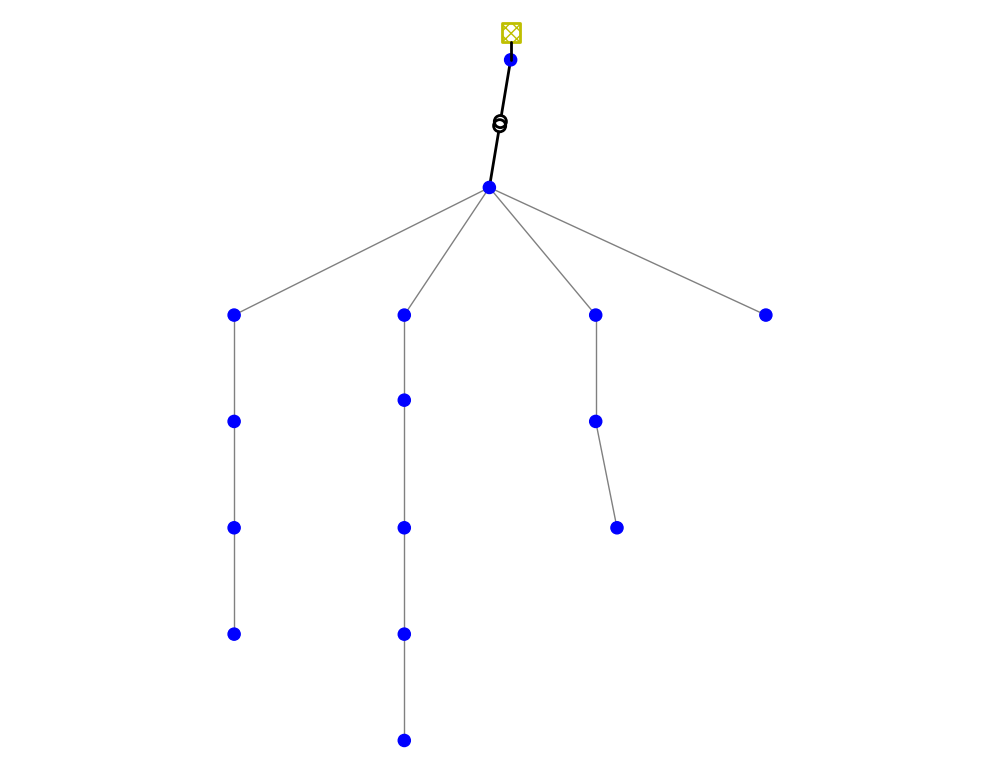

<Axes: >

In [5]:
pp.plotting.simple_plot(net, show_plot=True)

### Task 2a 

To calculate the annuities, we must first determine the investment costs of the lines and transformer types. For this purpose, read these from the Excel table using [the pandas function "read_excel"](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html).

In [8]:
line_std_types = pd.read_excel(io="./std_type_costs.xlsx", index_col=[0], sheet_name="line_std_types")
trafo_std_types = pd.read_excel(io="./std_type_costs.xlsx", index_col=[0], sheet_name="trafo_std_types")

### Task 2b
Calculate the total investment cost in t=0 for the transformer and the lines.
For the equipment with unit prices the total costs can be calculated via
$C_{inv} = \sum_{pc=1}^{n} {C_{pc}} = n \cdot C_{pc}$

In [9]:
trafo_name = net.trafo.std_type[0]
c_inv_trafo = len(net.trafo) * trafo_std_types.at[trafo_name, "cost_per_piece"]
print(f"The investment costs for trafos are : {round(c_inv_trafo/1e6, 2)} mio. €")

The investment costs for trafos are : 13.0 mio. €


For the equipment with length related costs:
$C_{inv} = \sum_{pc=1}^{n} {l_{pc} \cdot C_l} = (\sum_{pc=1}^{n} {l_{pc}}) \cdot C_l$.
First sum up over the total line length using [pandas groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

In [10]:
line_name = net.line.std_type[0]
sum_lines = net.line[["std_type", "length_km"]].groupby("std_type").sum().at[line_name, "length_km"]
print(f"The line length is : {round(sum_lines, 3)} km")

The line length is : 0.56 km


In [11]:
c_inv_lines = sum_lines * line_std_types.at[line_name, "cost_per_km"]
print(f"The investment costs for lines are : {round(c_inv_lines/1e6, 2)} mio. €")

The investment costs for lines are : 0.01 mio. €


Afterwards, calculate the total investment cost of the grid by:
$C_{grid,inv} = \sum_{equip.} {C_{inv,equip.}}$

In [12]:
c_total = c_inv_trafo + c_inv_lines
print(f"The total grid costs are : {round(c_total/1e6, 2)} mio. €")

The total grid costs are : 13.01 mio. €


### Task 2c
Calculate the annuity factors for the different lifetimes and components.
The annuity factors for the different lifetimes can be calculated via:
$a=\frac{q^{T,max} \cdot (q-1)}{q^{T,max}-1}$

The lifetimes $T_{max}$ of the assets can be found in the Excel tables or data frames. First, define a function to calculate the annuity. This should have the lifetime and the discount rate $q = 1+r$ as input data. Usually, distribution grid operators assume an interest rate of $r=5\%$.

In [13]:
interestrate=0.05

def annuity(n, r=interestrate):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r"""

    q=1+r

    if r > 0:
        return (q**n*(q-1))/(q**n-1)
    else:
        return 1/n

The following annuity costs then result for the components:

In [14]:
ann_lines = annuity(line_std_types.at[line_name, "lifetime"])
print(f"The annuity factor for the lines is : {round(ann_lines, 4)}")

The annuity factor for the lines is : 0.0611


In [15]:
ann_trafo = annuity(trafo_std_types.at[trafo_name, "lifetime"])
print(f"The annuity factor for the trafos is : {round(ann_trafo, 4)}")

The annuity factor for the trafos is : 0.0651


### Task 2d
Afterwards, calculate the operating costs for the transformer and the lines. The operating costs can be found in the corresponding Excel files or data frames. The operating costs correspond to the multiplication of the investment costs with the specific operating costs from the Excel table or data frame.

In [16]:
c_o_lines = c_inv_lines * line_std_types.at[line_name, "operating_cost"]
print(f"The operating costs for lines are : {round(c_o_lines, 2)} €")

The operating costs for lines are : 156.49 €


In [17]:
c_o_trafo = c_inv_trafo * trafo_std_types.at[trafo_name, "operating_cost"]
print(f"The operating costs for transformer are : {round(c_o_trafo/1e6, 2)} mio. €")

The operating costs for transformer are : 0.39 mio. €


### Task 2e
Calculate the annual cost of the grid equipment (sum of operating and investment costs).

In [18]:
c_ann_total = ann_lines * c_inv_lines + ann_trafo * c_inv_trafo + c_o_lines + c_o_trafo  
print(f"The annual grid costs are : {round(c_ann_total/1e6, 2)} mio. €")

The annual grid costs are : 1.24 mio. €


### Task 2f
In the course of digitizing the distribution grids, it is advisable to equip most of the LV system equipment with measurement technology. For our system, the following assumptions can be made:
- The specific investment costs for the measurement technology system in the transformer station is 500.000€, the interest rate equals 5%/a and its lifetime equals 20 years
- Every grid customer within our grid will also be equipped with a smart meter. As the smart meters belong to the metering point operator and not the distribution grid operator, there are no investment costs here.
- Because metering technology allows the grid to operate more efficiently, the lifetimes of all other technologies increase by 5 years

Calculate the new annuity of investment costs for the total system with the measurement technology

In [19]:
c_ann_trafo = 1 * trafo_std_types.at[trafo_name, "cost_per_piece"] * annuity(trafo_std_types.at[trafo_name, "lifetime"] + 5)
c_ann_lines = sum_lines * line_std_types.at[line_name, "cost_per_km"] * annuity(line_std_types.at[line_name, "lifetime"] + 5)

c_inv_measure = 500000
lifetime_measure = 20
c_ann_measure = annuity(lifetime_measure) * c_inv_measure

c_ann_total_new = c_ann_trafo + c_ann_lines + c_o_trafo + c_o_lines + c_ann_measure
print(f"The new annual grid costs are : {round(c_ann_total_new/1e6, 2)} mio. €")

The new annual grid costs are : 1.22 mio. €


### Task 2g
What are the maximum annual operating costs for the measurement equipment in order to still be cheaper than without measurement equipment?

In [20]:
c_o_measure = c_ann_total - c_ann_total_new
print(f"The maximum annual operating costs can be : {round(c_o_measure, 2)} €")

The maximum annual operating costs can be : 11651.6 €
